# Classification

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

#To save models
import joblib

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Where to save the models
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "model", CHAPTER_ID)
os.makedirs(MODELS_PATH, exist_ok=True)

def save_model(model,model_id, model_extension="pkl"):
    path = os.path.join(MODELS_PATH, model_id + "." + model_extension)
    print("Saving model", model_id)
    joblib.dump(model, path)

def load_model(model_id, model_path=MODELS_PATH, model_extension="pkl"):
    path = os.path.join(MODELS_PATH, model_id + "." + model_extension)
    print("Loading model "+model_id+ "...")
    return joblib.load(path)

## MNIST

In [ ]:
import os

os.makedirs(os.path.join(PROJECT_ROOT_DIR, "datasets", CHAPTER_ID), exist_ok=True)

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, data_home= os.path.join(PROJECT_ROOT_DIR, "datasets", CHAPTER_ID), as_frame=True)
mnist.keys()

In [2]:
import gzip

#We'll load the datasete as a file 
data_dir = os.path.join(r"openml\openml.org\data\v1\download")
filename = "52667"
file_ext = "gz"
def load_data():
    with gzip.open(os.path.join(PROJECT_ROOT_DIR, "datasets", 
                                CHAPTER_ID, data_dir, filename + "." + file_ext), "rb") as f:
        #Move the cursor to line 798 where the data starts
        for _ in range(797):
            f.readline()
        #Read each line, decode to utf-8 encoding and split by commas
        data =np.array([
            np.array(line.decode().split(','), dtype= np.uint8) for line in f
        ])
        #The result is a 70000x785 matrix. The 70000x784 matrix represent the data 
        #for the pixel values each row being an image and each column being a pixel
        #value. The last column are the labels for each image
        return data[:,:-1], data[:,-1]
        

In [3]:
X, y = load_data()

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
some_digit_image

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

Saving figure some_digit_plot


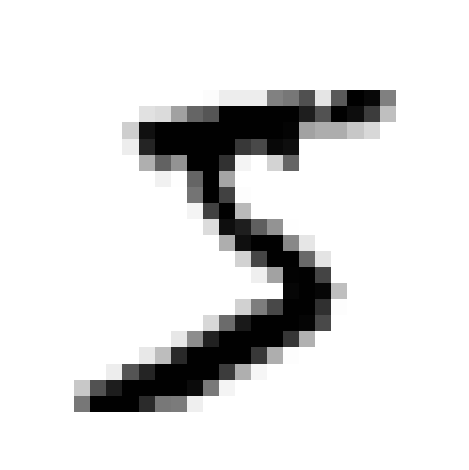

In [7]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
save_fig("some_digit_plot")
plt.show()

In [16]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [18]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


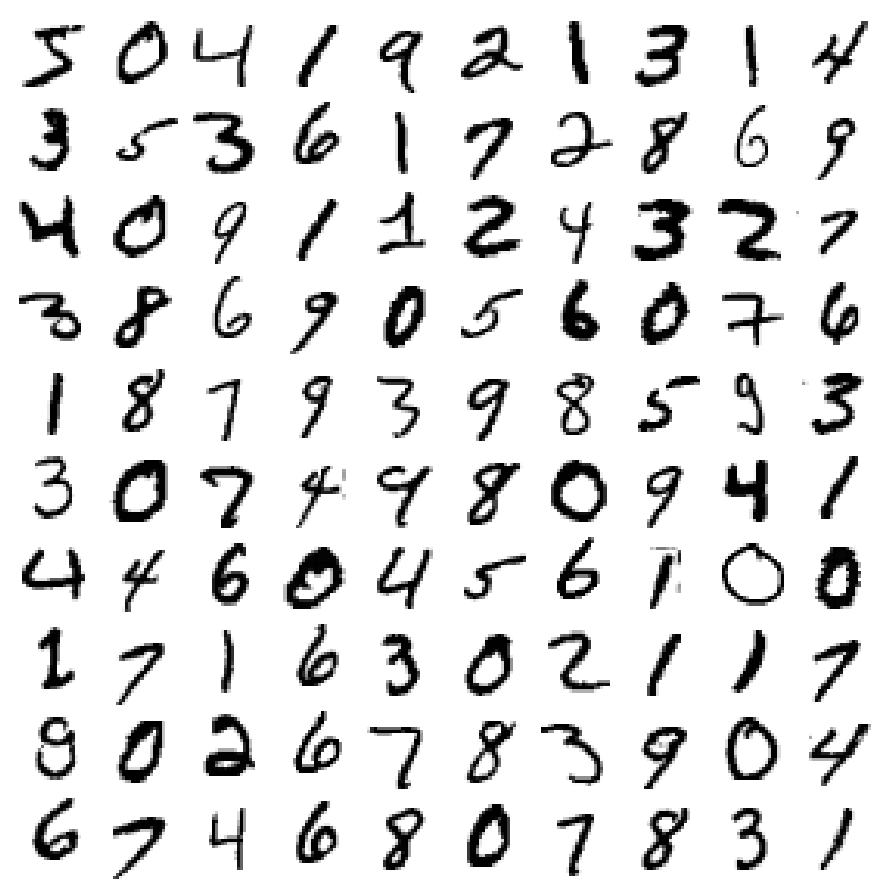

In [10]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [6]:
# Split the data into train and test sets

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


The training set is already shuffled for us, which is good because this guarantees that
all cross-validation folds will be similar (you don’t want one fold to be missing some
digits).

## Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for
this classification task:

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient
Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier
has the advantage of being capable of handling very large datasets efficiently. This is
in part because SGD deals with training instances independently, one at a time
(which also makes SGD well suited for online learning), as we will see later. Let’s create
an SGDClassifier and train it on the whole training set:

In [13]:
from sklearn.linear_model import SGDClassifier

#sgd_clf = SGDClassifier(random_state=42, n_jobs=-1)
#sgd_clf.fit(X_train, y_train_5)
save_model(sgd_clf,"SGDC_5_BinaryClassifier")

Saving model SGDC_5_BinaryClassifier


In [14]:
sgd_clf=load_model("SGDC_5_BinaryClassifier")

Loading model SGDC_5_BinaryClassifier...


In [15]:
sgd_clf.predict([some_digit])

#If True, it means that digit is a five

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

Let’s use the `cross_val_score()` function to evaluate our SGDClassifier model,
using K-fold cross-validation with three folds.

In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1)

array([0.95035, 0.96035, 0.9604 ])

We got above 95% accuracy. That must be wrong. Let's inspect our results by creating a classifier that just returns a numpy zeros matrix.

In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)


In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1)

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time. This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others).

### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion
matrix. The general idea is to count the number of times instances of class A are
classified as class B.

In [19]:
from sklearn.model_selection import cross_val_predict

#Just like the cross_val_score() function, cross_val_predict() performs K-fold
#cross-validation, but instead of returning the evaluation scores, it returns the predictions
#made on each test fold.

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents
a predicted class. The first row of this matrix considers non-5 images (the negative
class): 53,057 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 1,522 were wrongly classified as 5s (false positives).
The second row considers the images of 5s (the positive class): 1,325 were wrongly
classified as non-5s (false negatives), while the remaining 4,096 were correctly classified
as 5s (true positives).

In [21]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision and Recall

Precision is defined as the division between the true positive measure by the sum of true positive and false positive

Recall is defined as the division between the true positive measure by the sum of true positive and false negative

In [22]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

In [23]:
cm[1,1]/(cm[0,1]+cm[1,1]), cm[1,1]/(cm[1,0]+cm[1,1])

(0.8370879772350012, 0.6511713705958311)

It is often convenient to combine precision and recall into a single metric called the F1
score, in particular if you need a simple way to compare two classifiers. The F1 score is
the harmonic mean of precision and recall. Whereas the regular mean
treats all values equally, the harmonic mean gives much more weight to low values.
As a result, the classifier will only get a high F1 score if both recall and precision are
high.

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Trade-off

Scikit-Learn does not let you set the threshold directly, but it does give you access to
the decision scores that it uses to make predictions. Instead of calling the classifier’s
`predict()` method, you can call its `decision_function()` method, which returns a
score for each instance, and then use any threshold you want to make predictions
based on those scores:

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same
result as the `predict()` method (i.e., `True`). Let’s raise the threshold:

In [27]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [28]:
# To decide which threshold to use, we use the cross_val_predict() function to get the scores of all instances on the training set specifying the method as decision_function

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


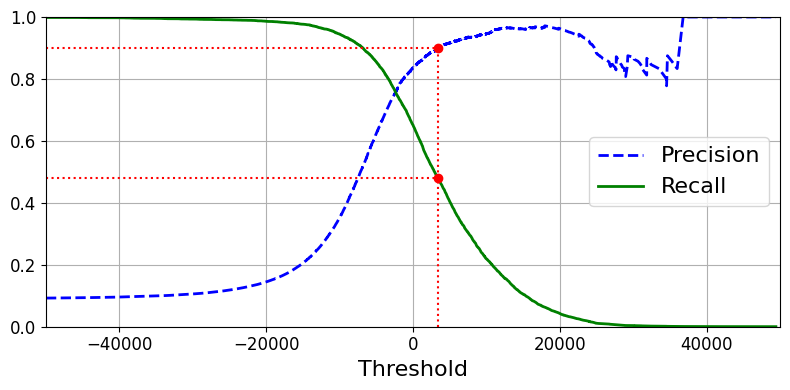

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

Saving figure precision_vs_recall_plot


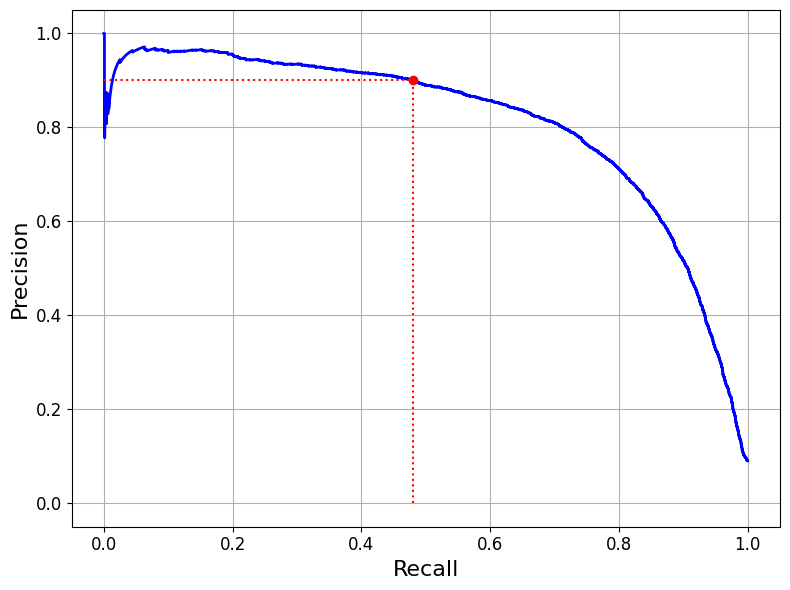

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)        # Not shown
    plt.ylabel("Precision", fontsize=16)
    plt.grid(True)                              # Not shown
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()


In [32]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [33]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. The ROC curve plots the true positive rate (another name
for recall) against the false positive rate (FPR). The FPR is the ratio of negative instances
that are incorrectly classified as positive.

Saving figure roc_curve_plot


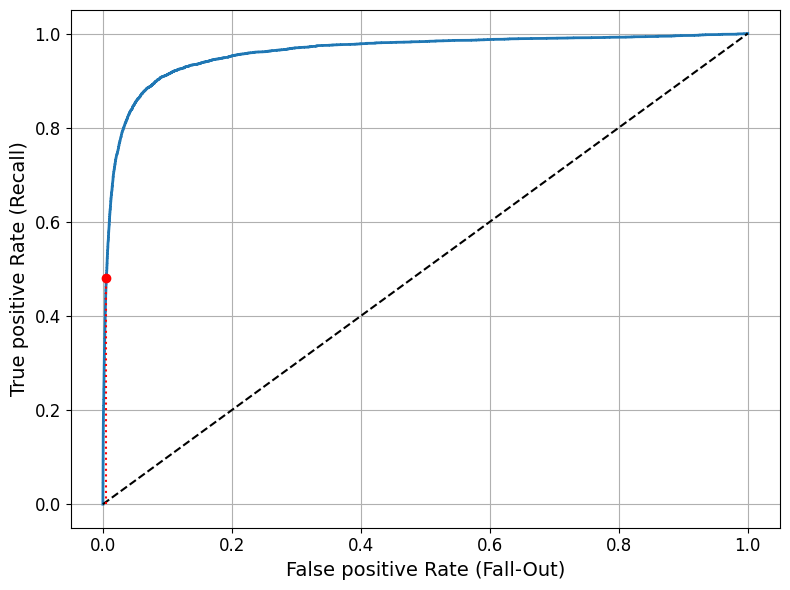

In [35]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--') #Dashed diagonal
    plt.ylabel('True positive Rate (Recall)')
    plt.xlabel('False positive Rate (Fall-Out)')
    plt.grid(True)

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr,tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [37]:
from sklearn.ensemble import RandomForestClassifier

y_probas_forest = cross_val_predict(RandomForestClassifier(n_estimators=100,
                                                           random_state=42),
                                    X_train, y_train_5, cv=3, n_jobs=-1,
                                    method="predict_proba")
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [38]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Saving figure roc_curve_comparison_plot


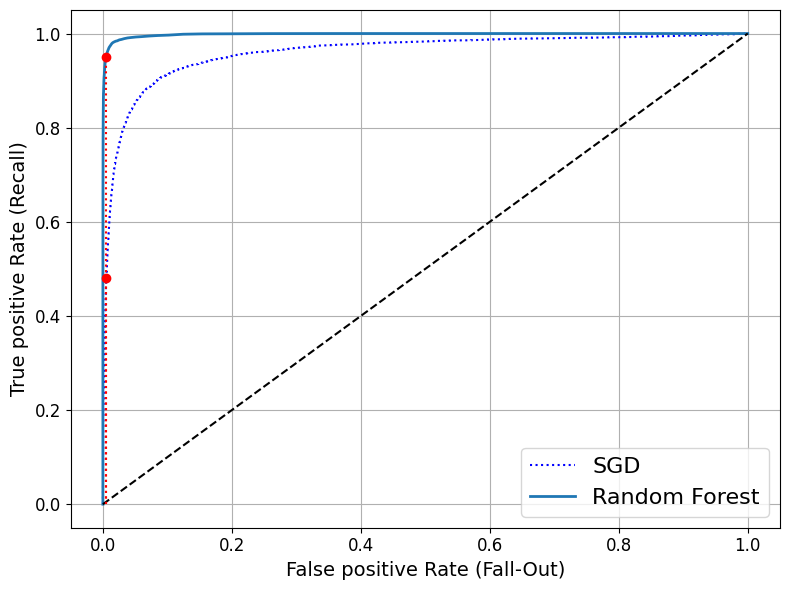

In [39]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", label="SGD")

plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

save_fig("roc_curve_comparison_plot")
plt.show()

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [41]:
y_pred_forest = cross_val_predict(RandomForestClassifier(n_estimators=100,
                                                           random_state=42),
                                    X_train, y_train_5, cv=3, n_jobs=-1)
precision_score(y_train_5, y_pred_forest)

0.9905083315756169

In [42]:
recall_score(y_train_5, y_pred_forest)

0.8662608374838591

## Multiclass Classification

In [43]:
from sklearn.svm import SVC
#svm_clf = SVC(random_state=42)
#svm_clf.fit(X_train, y_train)
#save_model(svm_clf,"SVM_DigitClassifier")
svm_clf=load_model("SVM_DigitClassifier")
svm_clf.predict([some_digit])

Loading model SVM_DigitClassifier...


array([5], dtype=uint8)

In [44]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [45]:
np.argmax(some_digit_scores)

5

In [46]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [47]:
svm_clf.classes_[5]

5

In [48]:
from sklearn.multiclass import OneVsRestClassifier

#ovr_clf = OneVsRestClassifier(SVC(random_state=42), n_jobs=-1)

In [49]:
#ovr_clf.fit(X_train, y_train)
#save_model(ovr_clf,"OVR_SVC_DigitClassifier")
ovr_clf=load_model("OVR_SVC_DigitClassifier")

Loading model OVR_SVC_DigitClassifier...


In [50]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [51]:
len(ovr_clf.estimators_)

10

In [52]:
#sgd_clf.fit(X_train, y_train)
#save_model(sgd_clf,"SGDC_DigitClassifier")
sgd_clf=load_model("SGDC_DigitClassifier")

Loading model SGDC_DigitClassifier...


In [53]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [54]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [55]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy",n_jobs=-1)

array([0.87365, 0.85835, 0.8689 ])

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_trained_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_trained_scaled, y_train, cv=3, scoring="accuracy",n_jobs=-1)

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [57]:
y_train_pred = cross_val_predict(sgd_clf, X_trained_scaled, y_train, cv=3, n_jobs=-1)

In [58]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

Saving figure confusion_matrix_plot


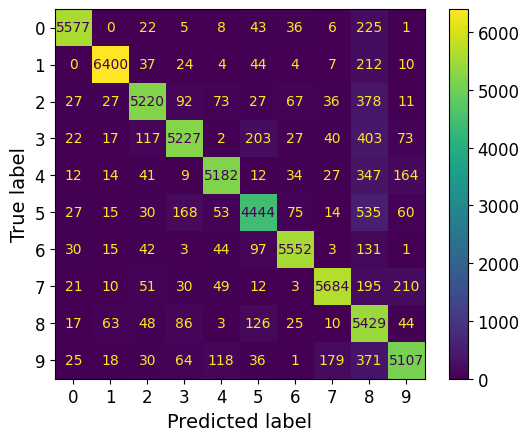

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay

disp=ConfusionMatrixDisplay(conf_mx)
disp.plot()
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [60]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
norm_conf_mx

array([[9.41583657e-01, 0.00000000e+00, 3.71433395e-03, 8.44166807e-04,
        1.35066689e-03, 7.25983454e-03, 6.07800101e-03, 1.01300017e-03,
        3.79875063e-02, 1.68833361e-04],
       [0.00000000e+00, 9.49273213e-01, 5.48798576e-03, 3.55977455e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.03826758e-03,
        3.14446752e-02, 1.48323939e-03],
       [4.53172205e-03, 4.53172205e-03, 8.76132931e-01, 1.54414233e-02,
        1.22524337e-02, 4.53172205e-03, 1.12453844e-02, 6.04229607e-03,
        6.34441088e-02, 1.84625713e-03],
       [3.58832164e-03, 2.77279400e-03, 1.90833469e-02, 8.52552602e-01,
        3.26211059e-04, 3.31104224e-02, 4.40384929e-03, 6.52422117e-03,
        6.57315283e-02, 1.19067036e-02],
       [2.05409106e-03, 2.39643958e-03, 7.01814447e-03, 1.54056830e-03,
        8.87024991e-01, 2.05409106e-03, 5.81992468e-03, 4.62170490e-03,
        5.93974666e-02, 2.80725779e-02],
       [4.98063088e-03, 2.76701716e-03, 5.53403431e-03, 3.09905921e-02,
   

Saving figure confusion_matrix_errors_plot


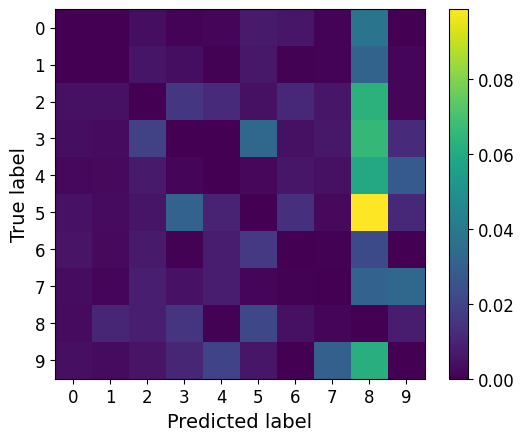

In [61]:
np.fill_diagonal(norm_conf_mx, 0)
disp = ConfusionMatrixDisplay(norm_conf_mx)
disp.plot(include_values=False)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

In [62]:
cl_a, cl_b = 3, 5

In [63]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

Saving figure error_analysis_digits_plot


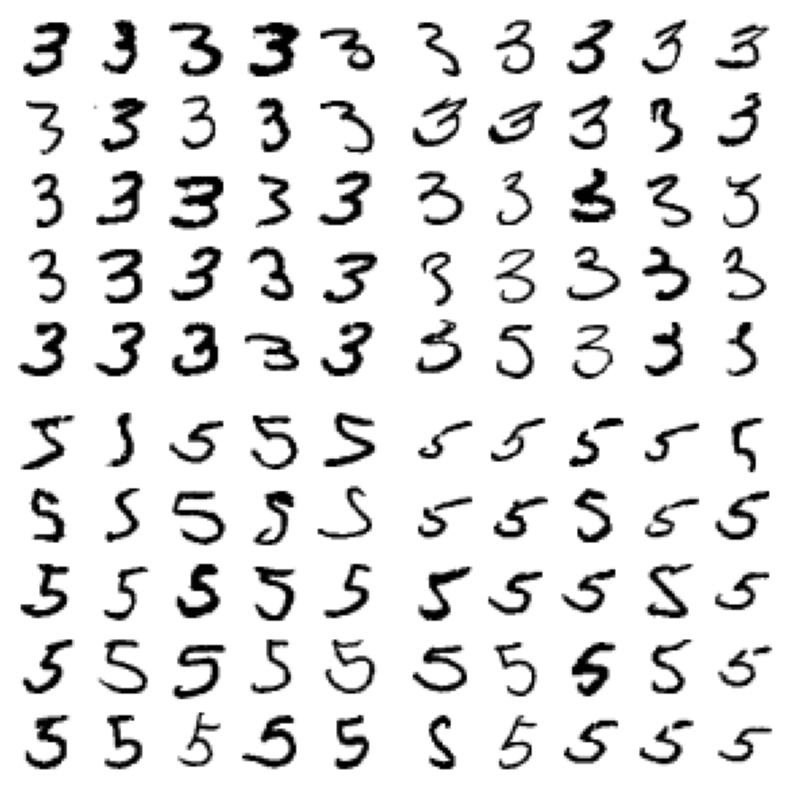

In [64]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

## Multilabel Classification

A classification system that outputs multiple binary tags at the input of one instance.

In [65]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [66]:
#knn_clf = KNeighborsClassifier(n_jobs=-1)
#knn_clf.fit(X_train, y_multilabel)
#save_model(knn_clf,"KNN_MultilabelClassifier")
knn_clf = load_model("KNN_MultilabelClassifier")

Loading model KNN_MultilabelClassifier...


In [67]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [68]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Multioutput Classification

Multioutput Classification is a generalization
of multilabel classification where each label can be multiclass (i.e., it can have
more than two possible values).

To illustrate this, let’s build a system that removes noise from images. It will take as
input a noisy digit image, and it will (hopefully) output a clean digit image, represented
as an array of pixel intensities, just like the MNIST images. Notice that the
classifier’s output is multilabel (one label per pixel) and each label can have multiple
values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput
classification system.

In [69]:
noise = np.random.randint(0,100,(len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test = X_test

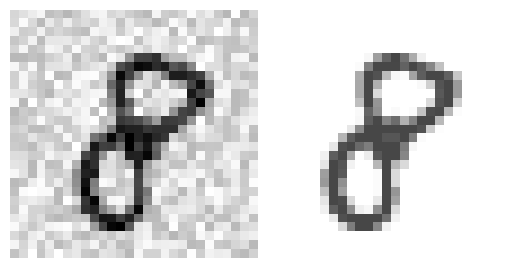

In [70]:
some_ind = np.random.randint(0,len(X_test))
plot_digits(np.concatenate(([X_test_mod[some_ind]],
                             [X_test[some_ind]])))

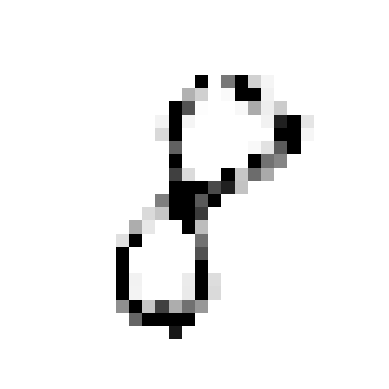

In [71]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_ind]])
plot_digit(clean_digit)

## Exercises

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'n_neighbors': [2,3,4,5], #10, 25, 50, 100, 500, 1000],
    'weights': ['uniform', 'distance'],
    #'algorithm': [ 'bsll_tree', 'kd_tree', 'brute'],
    #'leaf_size': [10, 30, 60, 200, 500],
    #'p': [1,2],
    #'metric': ['cityblock', 'cosine', 'euclidean', 
    #           'haversine','l1', 'l2',
    #           'manhattan', 'nan_euclidean']
}]
#Takes too long to run them all
#gridsrc_knnc = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, n_jobs=1,
#                           verbose=3, return_train_score=True)

#Re-run cell where we load and separate the test and training sets
#gridsrc_knnc.fit(X_train, y_train)
#save_model(gridsrc_knnc, 'GridSearch_KNN_NumClassifier')
gridsrc_knnc = load_model('GridSearch_KNN_NumClassifier')

Loading model GridSearch_KNN_NumClassifier...


In [8]:
gridsrc_knnc.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [9]:
gridsrc_knnc.best_score_

0.9703500000000002

In [10]:
y_pred= gridsrc_knnc.best_estimator_.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9714

2. Write a function that can shift an MNIST image in any direction (left, right, up,
or down) by one pixel.5 Then, for each image in the training set, create four shifted
copies (one per direction) and add them to the training set. Finally, train your
best model on this expanded training set and measure its accuracy on the test set.
You should observe that your model performs even better now! This technique of
artificially growing the training set is called data augmentation or training set
expansion.

In [12]:
from scipy.ndimage import shift

def shift_image(image: np.array, dx: int, dy: int):
    image = image.reshape((28,28))
    image = shift(image, [dy, dx], cval=0, mode = "constant")
    return np.reshape(image,-1)
    

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataAugmentionTransform(BaseEstimator, TransformerMixin):
    def __init__(self, max_var):
        if max_var > 10:
            self.max_var = 10
        else:
            self.max_var = max_var
    def fit_transform(self, X, y):
        X_shifted = np.array(
            [
            np.array([
                shift_image(image,
                            *(np.random.randint(0,self.max_var,2)*np.array(dir))) \
                            for dir in zip([-1,-1,1,1],[-1,1,-1,1])]) \
                                  for image in X])
        return np.c_[
            X, X_shifted[:,0], 
            X_shifted[:,1], 
            X_shifted[:,2], 
            X_shifted[:,3]
            ].reshape((-1,len(X[0]))), \
            np.c_[y, y, y, y, y].reshape(-1)


In [14]:
train_set_expan = DataAugmentionTransform(2)
X_train_expanded, y_train_expanded = train_set_expan.fit_transform(X_train, y_train)
shuffle_idx = np.random.permutation(len(X_train_expanded))
X_train_expanded = X_train_expanded[shuffle_idx]
y_train_expanded = y_train_expanded[shuffle_idx]

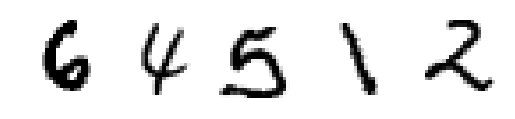

In [19]:
plot_digits(X_train_expanded[:5])

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(**gridsrc_knnc.best_params_)

In [23]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [24]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9719

3. Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic).

In [2]:
os.environ['KAGGLE_USERNAME'] = "ivannykaley"
os.environ['KAGGLE_KEY'] = "661f2888f3b8d93e79a5970585aaaa3b"


from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

In [3]:
data_folder = 'titanic_dataset'
dataset_name = 'titanic.zip'
#api.dataset_download_files('titanic/data', 
#                           os.path.join(PROJECT_ROOT_DIR, 'datasets', CHAPTER_ID, 
#                                        'titanic_dataset'))

In [4]:
from zipfile import ZipFile

titanic_data_dir = os.path.join(PROJECT_ROOT_DIR, 'datasets', CHAPTER_ID, data_folder)

In [51]:
with ZipFile(os.path.join(titanic_data_dir, dataset_name), 'r') as f:
    f.extractall(titanic_data_dir)

In [5]:
import pandas as pd 

train_data = pd.read_csv(os.path.join(titanic_data_dir,'train.csv'), index_col=0)

In [6]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Add a couple of features to the titanic data set

First, we'll add a feature called `Title` from the names feature

Saving figure scatter_matrix_plot


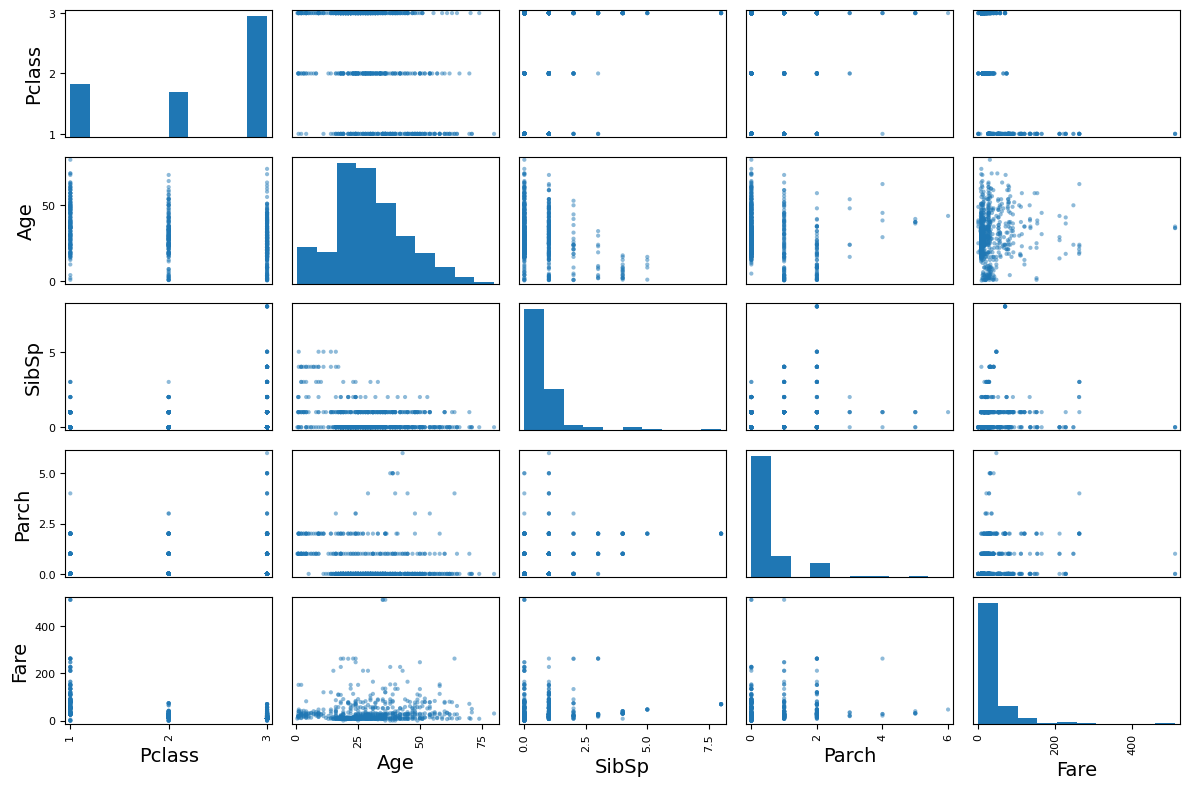

In [7]:
from pandas.plotting import scatter_matrix

#Check if there is correlation between numerical attributes

num_atr = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

scatter_matrix(train_data[num_atr], figsize=(12,8))
save_fig('scatter_matrix_plot')

In [8]:
corr_matrix = train_data.corr(numeric_only=True)
corr_matrix

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [9]:
#Fill missing Age values with median values

train_data['Age'].fillna(train_data['Age'].median(), inplace=True)

In [10]:
#Combine of the features to see if we increase correlation

train_data['Pclass*Age'] = train_data['Pclass']*train_data['Age']
train_data['Pclass*Fare'] = train_data['Pclass']*train_data['Fare']

In [11]:
corr_matrix = train_data.corr(numeric_only=True)
corr_matrix['Survived']

Survived       1.000000
Pclass        -0.338481
Age           -0.064910
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Pclass*Age    -0.324559
Pclass*Fare    0.183627
Name: Survived, dtype: float64

In [12]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    print (big_string)
    return np.nan

In [13]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

In [14]:
train_data['Title']=train_data['Name'].map(lambda x: substrings_in_string(x, title_list))
 
#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
train_data['Title']=train_data.apply(replace_titles, axis=1)

In [15]:
train_data['Cabin'].fillna('Unknown', inplace=True)

In [16]:
#Turning cabin number into Deck

cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
train_data['Cabin'] = train_data['Cabin'].astype(str)
train_data['Deck']=train_data['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

In [17]:
train_data['Family_Size'] = train_data['SibSp']+train_data['Parch']

In [18]:
train_data['Fare_per_person'] = train_data['Fare']/(train_data['Family_Size']+1)

In [19]:
train_data['Embarked'].fillna('Unknown', inplace=True)

In [20]:
#Drop features: Name, Ticket, Cabin because there's no more info to be extracted for now

train_data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [21]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

In [22]:
cat_atribs_feat = ['Sex','Embarked','Title', 'Deck']
cat_atribs = encoder.fit_transform(train_data[cat_atribs_feat].values)


In [23]:
i=0
for cats in encoder.categories_:
    for feat in cats:
        train_data[feat] = cat_atribs[:, i]
        i+=1

In [24]:
train_data.drop(cat_atribs_feat, axis=1, inplace=True)

Choose and train the model

In [25]:
X_train, y_train = train_data.iloc[:, 1:].values, train_data.iloc[:,0].values

In [26]:
X_train, y_train

(array([[ 3., 22.,  1., ...,  0.,  0.,  0.],
        [ 1., 38.,  1., ...,  0.,  0.,  0.],
        [ 3., 26.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 3., 28.,  1., ...,  0.,  0.,  0.],
        [ 1., 26.,  0., ...,  0.,  0.,  0.],
        [ 3., 32.,  0., ...,  0.,  0.,  0.]]),
 array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,

In [27]:
X_train.shape, y_train.shape

((891, 26), (891,))

In [28]:
from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier()


In [29]:
from sklearn.model_selection import cross_val_predict

y_best_pred = cross_val_predict(model, X_train, y_train, cv=3)

In [30]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, y_best_pred)
conf_mx

array([[484,  65],
       [ 98, 244]], dtype=int64)

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_train, y_best_pred), recall_score(y_train, y_best_pred), f1_score(y_train, y_best_pred)

(0.7896440129449838, 0.7134502923976608, 0.7496159754224271)

In [57]:
from scipy import stats

stats.expon().rvs(5)

array([1.31778302, 0.00335197, 0.62981708, 0.35240248, 1.91611133])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distrib = [
    {
    'learning_rate'
    }
]

rnd_hgbclf = RandomizedSearchCV(model, )
